In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="4" #4번 DEVICES만 사용하여 다른 메모리를 낭비를 방지
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
#costomized seq2seq cell
import copy
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import variable_scope

In [2]:

#=======================================Hyperparameter 
learning_rate = 0.001
total_epoch = 1000
batch_size = 100 
dropout = 0.5
hidden_size = 200
index = 0

feed_train = {}
feed_val = {}
outputs = []
targets = []
DATAS = []
data_size = 50

#훈련에 사용할 데이터 이름을 배열로 저장한다. 
traindatasets = ['Plane', 'GunPoint', 'ArrowHead', 'WordSynonyms', 'ToeSegmentation1', 'FISH', 'ShapeletSim', 'ShapesAll', 'SonyAIBORobotSurface1',
             'Lightning7', 'ToeSegmentation2', 'DiatomSizeReduction', 'Ham', 'SonyAIBORobotSurface2', 'TwoLeadECG', 'FacesUCR']

In [3]:
def customized_rnn_seq2seq(encoder_inputs,
                          decoder_inputs,
                          cell,
                          dtype=dtypes.float32,
                          scope=None):
    
    with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
        enc_cell = copy.deepcopy(cell)
        encoder_outputs, enc_state = tf.contrib.rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
    return customized_rnn_decoder(encoder_outputs, decoder_inputs, enc_state, cell)

def customized_rnn_decoder(encoder_outputs,
                decoder_inputs,
                initial_state,
                cell,
                loop_function=None,
                scope=None):
    
    with variable_scope.variable_scope(scope or "rnn_decoder"):
        state = initial_state
        outputs = []
        prev = None
        for i, inp in enumerate(decoder_inputs):
            if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                    inp = loop_function(prev, i)
            if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
            output, state = cell(inp, state)
            outputs.append(output)
            if loop_function is not None:
                prev = output
    return encoder_outputs, outputs, state

def data_maker(dataset):
    print(dataset)
    #train 숫자가 너무 작아서 concatenate이후 train_test_split를 이용해 다시 나눈다.
    datadir = 'UCRArchive_2018' + '/' + dataset + '/' + dataset
    data_train = np.loadtxt(datadir+'_TRAIN.tsv', delimiter='\t')
    data_test = np.loadtxt(datadir+'_TEST.tsv', delimiter='\t')
    DATA = np.concatenate((data_train,data_test),axis=0)
    
    #특정 데이터의 y lable이 1부터 시작해 range error 발생.첫 인덱스가 1이면 1을 빼서 0으로 만듬
    X_data = DATA[:,1:]
    y_data = DATA[:,[0]]
    y_first_index = int(np.unique(y_data)[0])
    if int(y_first_index) == 1:
        y_data = DATA[:,[0]]-1
    DATA = np.concatenate((y_data, X_data), axis=1)
    
    #50행마다 잘라서 DATAS 배열에 저정
    iter = DATA.shape[0]//data_size
    for i in range(iter):
        CUT_DATA = DATA[50*i:50*(i+1),:]
        DATAS.append(CUT_DATA)
    
def seq2seq_maker(index, DATA):

    X_data = DATA[:,1:]
    y_data = DATA[:,0]
    
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
    
    encoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]]) 
    decoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    target = tf.placeholder(tf.int64, [None])

    targets.append(target)
    
    with tf.variable_scope("rnn_"+str(index)):
        cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
        #output, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_input], [decoder_input], cell)
        en_outputs, de_outputs, state = customized_rnn_seq2seq([encoder_input], [decoder_input], cell)
        #print("encoder_outputs", encoder_outputs)
        #print("decoder_outputs", decoder_outputs)
        de_outputs = tf.reshape(de_outputs, [-1, hidden_size]) #3D -> 2D
        outputs.append(de_outputs)
    
    feed_train[encoder_input] = X_train
    feed_train[decoder_input] = X_train
    feed_train[target] = y_train
    
    feed_val[encoder_input] = X_val
    feed_val[decoder_input] = X_val
    feed_val[target] = y_val

In [4]:
import copy
#data_maker('Plane')        
for dataset in traindatasets:
    data_maker(dataset)    
    
for index, DATA in enumerate(DATAS):
    seq2seq_maker(index, DATA)

Plane
GunPoint
ArrowHead
WordSynonyms
ToeSegmentation1
FISH
ShapeletSim
ShapesAll
SonyAIBORobotSurface1
Lightning7
ToeSegmentation2
DiatomSizeReduction
Ham
SonyAIBORobotSurface2
TwoLeadECG
FacesUCR
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructio

In [5]:
W = tf.Variable(tf.random_normal([hidden_size, 100]), name="W") 
b = tf.Variable(tf.random_normal([100]), name="b") #최대 클래수의 갯수인 60보다는 커야 range 에러 안생김
print("W", W)
print("b", b)
logits = [tf.matmul(output, W) + b for output in outputs]

with tf.variable_scope("cost"):
    loss = []
    for logit, target in zip(logits, targets):
        loss.append(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target))
    #cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    cost= tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    
#with tf.variable_scope("eval"):
#    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
#    correct_prediction = tf.equal(prediction, targets)#one-hot을 안쓰면 target에는 argmax할 필요없음
#    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W <tf.Variable 'W:0' shape=(200, 100) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(100,) dtype=float32_ref>


[[-1.7752874   2.0469844   0.36769435 ... -0.8887142  -0.39307138
  -0.18026935]
 [ 0.35898998  1.1710458  -0.5539473  ...  1.610424   -0.3653937
   0.2267573 ]
 [ 1.7162745   3.4374948   0.18480867 ... -0.33494365 -0.70481473
   1.5762633 ]
 ...
 [ 1.0546646   2.1506813  -1.7801001  ... -0.08220769  1.5439498
   1.8349516 ]
 [-2.4351687   1.5379708  -0.27892506 ... -2.2651443   0.2654991
   0.12807518]
 [ 0.6646134   0.41552642 -1.6548251  ... -0.5516775   0.41803804
   0.48632395]]
[ 1.0229144   0.10713756  1.2602333  -0.18442847  1.0593863   0.5241448
  0.38003686  2.0510676   0.34854162 -0.46839184 -1.3516546  -1.2927005
  0.2775945   0.45241794  1.7855079   0.1428486   2.197832   -0.05300001
  0.56384265 -0.3621135   1.0877128   1.0643741  -1.7113878  -1.8861148
  0.49191344 -1.0251831  -1.8322444  -0.19497852 -0.0093414   0.5123816
 -0.63917947  0.29399693 -0.3947946  -0.03477793 -0.22016911  0.18740991
 -0.6377595  -0.6909403   1.8086764   0.1957868   1.1917068   0.3121187
  0.5

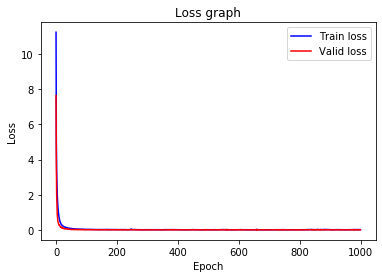

[[-1.7284567   2.05269     0.40483415 ... -0.854966   -0.34325504
  -0.17232311]
 [ 0.43552798  1.1929252  -0.6938882  ...  1.5337152  -0.3543816
   0.23690172]
 [ 1.773098    3.3432832   0.16986354 ... -0.319354   -0.69197303
   1.5099975 ]
 ...
 [ 1.1676127   2.0779474  -1.6909802  ... -0.12395951  1.4972156
   1.7547349 ]
 [-2.4309518   1.5244138  -0.22376706 ... -2.2099066   0.2634362
   0.14904453]
 [ 0.74781716  0.47769055 -1.6354996  ... -0.5439584   0.37198693
   0.44186816]]
[ 1.0554953   0.13200715  1.3497628  -0.08985579  1.1039551   0.62838703
  0.49179208  2.0151026   0.38626596 -0.44754857 -1.3280872  -1.2626417
  0.30824035  0.42201585  1.7576851   0.08711861  2.1643758  -0.08977063
  0.48551452 -0.42499292  1.0428873   1.0349277  -1.706072   -1.8644013
  0.46023548 -1.0863844  -1.9255868  -0.2376011  -0.04339891  0.48300266
 -0.7015836   0.2553724  -0.44430754 -0.10291735 -0.22453512  0.1131088
 -0.69227767 -0.7583144   1.7773801   0.14792427  1.1550161   0.26683602
  0

In [6]:
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("============================sess init")
    start_time = time.time()
    train_losses = []
    valid_losses = []
    for epoch in range(total_epoch):
        _, tr_loss = sess.run([optimizer, cost], feed_dict = feed_train)
        _, va_loss = sess.run([optimizer, cost], feed_dict = feed_val)
        train_losses += [tr_loss]
        valid_losses += [va_loss]
        if epoch % 100 == 0:  
            print("Epoch {}/{} took {:.3f}s".format(epoch + 1, total_epoch,time.time() - start_time))
            print("  Train      loss : %.6f"%(train_losses[epoch]))
            print("  Validation loss : %.6f"%(valid_losses[epoch]))
    print("It took", time.time() - start_time, "seconds to train for", total_epoch, "epochs.")        
    print("============================ training end")
    
    #loss  그래프를 확인한다. 
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(valid_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #print('Accuracy:', sess.run(accuracy_op, feed_dict=feed_dict))
    
    #pred = sess.run(prediction, feed_dict=feed_dict)
    #for p, i in zip(pred, y_test.flatten()):
    #    print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))
        
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    save_path = saver.save(sess, "./180123.ckpt")
    print("model saved!")

In [2]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph("./180123.ckpt.meta")

In [3]:

learning_rate = 0.001
total_epoch = 1000
batch_size = 100 
dropout = 0.5
hidden_size = 200
index = 0

dataset = 'Coffee'
datadir = 'UCRArchive_2018' + '/' + dataset + '/' + dataset
data_train = np.loadtxt(datadir+'_TRAIN.tsv', delimiter='\t')
data_test = np.loadtxt(datadir+'_TEST.tsv', delimiter='\t')

#train 숫자가 너무 작아서 concatenate이후 train_test_split를 이용해 다시 나눈다.
DATA = np.concatenate((data_train,data_test),axis=0)
X_data_n = DATA[:,1:]
y_data_n = DATA[:,0]

#특정 데이터의 y lable이 1부터 시작해 range error 발생.첫 인덱스가 1이면 1을 빼서 0으로 만듬
y_first_index = int(np.unique(y_data_n)[0])
if int(y_first_index) == 1:
    y_data_n = DATA[:,0]-1

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_data_n, y_data_n, test_size=0.2, random_state=1)
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n, y_train_n, test_size=0.2, random_state=1)

n_variable = X_train_n.shape[1]

# placeholder
encoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="encoder_inputs")
decoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="decoder_inputs")
targets = tf.placeholder(tf.int64, [None], name="targets")

with tf.variable_scope("seq2seq"+dataset):  
    cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
    outputs, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_inputs], [decoder_inputs], cell)
    outputs = tf.reshape(outputs, [-1, hidden_size]) #3D -> 2D
    print("outputs", outputs)  # output 모양이 항상 [? , hidden_size]으로 고정됨
    print("states", states)
    
    
    W = tf.get_default_graph().get_tensor_by_name("W:0")
    b = tf.get_default_graph().get_tensor_by_name("b:0")
    print("W", W)
    print("b", b)
    logits = tf.matmul(outputs, W) + b

with tf.variable_scope("cost"+dataset):
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

#print(optimizer)
    
with tf.variable_scope("eval"+dataset):
    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
    correct_prediction = tf.equal(prediction, targets)#one-hot을 안쓰면 target에는 argmax할 필요없음
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
outputs Tensor("seq2seqCoffee/Reshape:0", shape=(?, 200), dtype=float32)
states Tensor("se

In [4]:
train_losses = []
val_losses = []

new_saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "./180123.ckpt")
    print("... check point loaded")
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("=============================== training", dataset)
    start_time = time.time()
    # 비용함수을 학습시킨다. 
    for epoch in range(total_epoch):
        #Minibatch 
        batch_mask = np.random.choice(len(X_train_n), batch_size)
        X_batch = X_train_n[batch_mask]
        y_batch = y_train_n[batch_mask]

        # Compute the losses, 훈련을 통해 w,b가 계속 조정되고 그로 인해 변하는 정확성이나 비용함수를 측정하는 것
        _, tr_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_batch, decoder_inputs: X_batch, targets: y_batch})
        _, val_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_val_n, decoder_inputs: X_val_n,targets: y_val_n})
        # Log the losses
        train_losses += [tr_loss]
        val_losses += [val_loss]
  
        if epoch % 100 == 0:  
            print("Epoch {}/1000 took {:.3f}s".format(epoch + 1, time.time() - start_time))
            print("  Train loss : %.6f"%(train_losses[epoch]))
            print("  valid loss : %.6f"%(val_losses[epoch]))

    print("============================ training end")
    print('Accuracy:', sess.run(accuracy_op, feed_dict={encoder_inputs: X_test_n, decoder_inputs: X_test_n, targets: y_test_n}))
    
    pred = sess.run(prediction, feed_dict={encoder_inputs: X_test_n, decoder_inputs: X_test_n})
    for p, i in zip(pred, y_test_n.flatten()):
        print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))

INFO:tensorflow:Restoring parameters from ./180123.ckpt
... check point loaded
[[ 2.2213447   0.3219719   0.490732   ...  0.4942872   0.83331865
   2.3464181 ]
 [ 0.9293427  -0.5835477  -0.60782105 ... -0.7719066   0.09963955
   0.48788664]
 [-0.6694349  -0.43705964  0.8162472  ... -1.2734629   1.355652
   0.48305488]
 ...
 [-1.0361733   0.13412148  0.30746385 ... -1.0050983   0.26483974
  -0.40772647]
 [ 0.58828133  0.6410695  -1.0061091  ... -0.98361045  0.06794253
   0.02531427]
 [-0.769398   -1.3087723   0.00831522 ... -0.22830899  0.42123502
  -0.62423563]]
[ 2.6085396  -0.13781853  0.5079586   0.7505565  -1.6711701  -1.1244154
 -1.2220967  -0.9417593  -0.75413495  0.7835153   0.76824826  0.01421006
 -0.84674037 -0.36326706 -0.89012754  1.6949654  -0.17451143 -0.17321901
  0.25079346  0.96105075 -0.19576448  0.18262634 -0.04339788 -0.44675002
  0.03818896 -0.5850081   0.45266193  0.30945715 -0.03430903  0.50403404
  0.3875951   0.7881022  -0.9923665   1.1446277   0.35451147 -0.781